In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import timeit

# Загрузка данных
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
full_data = pd.concat([train_data, test_data])

train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Преобразование меток в числовые значения
le = LabelEncoder()
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')
train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
# Определение датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    
# Определение модели Bidirectional LSTM
class BidirectionalLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Умножаем на 2 из-за двунаправленности

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [6]:
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 89/89 [00:00<00:00, 94.86it/s]


Epoch 1, Train Loss: 3.2866829132223265, Val Loss: 1.2166202423277865


100%|██████████| 89/89 [00:00<00:00, 99.01it/s] 


Epoch 2, Train Loss: 0.5323348841590347, Val Loss: 0.24224323754230243


100%|██████████| 89/89 [00:00<00:00, 98.37it/s]


Epoch 3, Train Loss: 0.1669166168467097, Val Loss: 0.15216536962249305


100%|██████████| 89/89 [00:00<00:00, 96.92it/s]


Epoch 4, Train Loss: 0.11675397040739276, Val Loss: 0.1298648469945353


100%|██████████| 89/89 [00:00<00:00, 100.54it/s]


Epoch 5, Train Loss: 0.10117640969456931, Val Loss: 0.12542114329388301


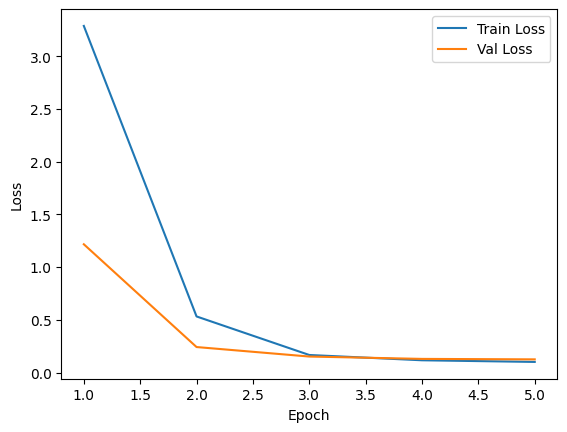

In [7]:
# Инициализация модели
model = BidirectionalLSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_losses = []
val_losses = []

n_epoches = 10

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0

    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [8]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.float().to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy()) 
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.8937 seconds
Average time per response: 0.000317 seconds
0.9525765767854389
(0.9507674075934389, 0.9518243003896564, 0.9493774745089179, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
